In [ ]:
import abc

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from scipy.linalg import toeplitz
from scipy.integrate import dblquad
from scipy.sparse.linalg import cg, LinearOperator
from scipy.sparse.linalg import gmres
import time

In [ ]:
# Parameters

lambda0 = 1.0  # Free Space Wavelength
a = 0.001 * lambda0  # Wire Radius
L = 0.5 * lambda0  # Half-Length of the Wire
V0 = 1  # Source Voltage
eps0 = 1 / (36 * np.pi) * 1e-9  # Free Space Permittivity
mu0 = 4 * np.pi * 1e-7  # Free Space Permeability
etta0 = np.sqrt(mu0 / eps0)  # Intrinsic Impedance of Free Space
k0 = 2 * np.pi / lambda0  # Wave Number

In [ ]:
class gmres_counter(object):
    def __init__(self, disp=False):
        self._disp = disp
        self.niter = 0
    def __call__(self, rk=None):
        self.niter += 1
        if self._disp:
            print('iter %3i\trk = %s' % (self.niter, str(rk)))

N = 21 , Time: 0.0031 sec, Iterations: 11
N = 51 , Time: 0.0094 sec, Iterations: 25
N = 81 , Time: 0.4848 sec, Iterations: 35
N = 101 , Time: 0.0276 sec, Iterations: 39


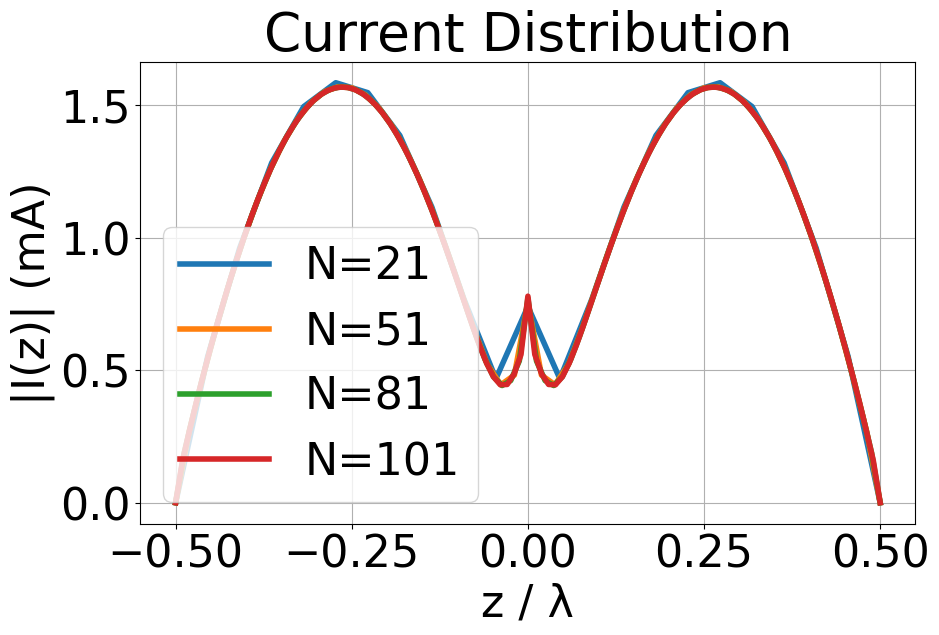

In [ ]:
# Full-precision Convergence

num_of_segments = [21, 51, 81, 101]

plt.figure(figsize=(10, 6))
plt.rcParams.update({'font.size': 32})


for N in num_of_segments:

  # Points
  dz = 2 * L / (N + 1)
  zn = np.linspace(-L, L, N + 2)

  # Psi calculation using Reff approach
  Reff = np.zeros(N + 1)
  for n in range(N+1):
      delta = (n - 1) * dz
      alpha = 2 * dz + delta
      beta = dz + delta
      Reff[n] = dz**2 / (
          alpha * np.arcsinh(alpha / a)
          - 2 * beta * np.arcsinh(beta / a)
          + delta * np.arcsinh(delta / a)
          - np.sqrt(alpha**2 + a**2)
          - np.sqrt(delta**2 + a**2)
          + 2 * np.sqrt(beta**2 + a**2)
      )

  psi = np.exp(-1j * k0 * Reff) / (4 * np.pi * Reff)

  # # Alternative Psi calculation using double integration
  # def integrand(z1, z2):
  #     R = np.sqrt((z1 - z2) ** 2 + a**2)
  #     return np.exp(-1j * k0 * R) / (4 * np.pi * R)

  # psi_alt = np.zeros(N, dtype=complex)
  # for n in range(1, N + 1):
  #     z_prime = (n - 1) * dz
  #     result, _ = dblquad(
  #         integrand,
  #         z_prime - dz / 2,
  #         z_prime + dz / 2,
  #         lambda x: -dz / 2,
  #         lambda x: dz / 2,
  #     )
  #     psi_alt[n - 1] = result / dz**2

  # psi = psi_alt

  # Constructing F and C matrices
  F = 1j * k0 * etta0 * dz**2 * psi[:N]
  C = (
      -1j
      * etta0
      / k0
      * (2 * psi[:N] - psi[1:N + 1] - np.concatenate(([psi[1]], psi[:N - 1])))
  )

  # Constructing the system matrix A
  A_row = C + F
  A = toeplitz(A_row, A_row)

  # Delta Gap Excitation
  b = np.zeros(N, dtype=complex)
  b[(N - 1) // 2] = V0

  # Iterative Solver using GMRES
  tol = 1e-4
  maxit = N
  x0 = np.random.rand(len(b)) * b  # Initial guess

  counter = gmres_counter()

  # Solve the system using GMRES
  start_time = time.time()
  x, exitCode = gmres(A, b, x0=x0, rtol=tol, maxiter=maxit, restart= N
                      , callback=counter)
  end_time = time.time()

  print(f"N = {N} , Time: {end_time - start_time:.4f} sec, Iterations: {counter.niter}")

  # Append zeros to the current distribution
  I = np.concatenate(([0], x, [0]))

  # Final Current Distribution Display

  plt.plot(zn / lambda0, np.abs(I) * 1e3, linewidth=4, label=f"N={N}")
  plt.xlabel("z / λ")
  plt.ylabel("|I(z)| (mA)")
  plt.title("Current Distribution")
  plt.grid(True)
  plt.legend()


plt.show()

Text(0.5, 1.0, 'QAM Constellation (QAM Side = 16)')

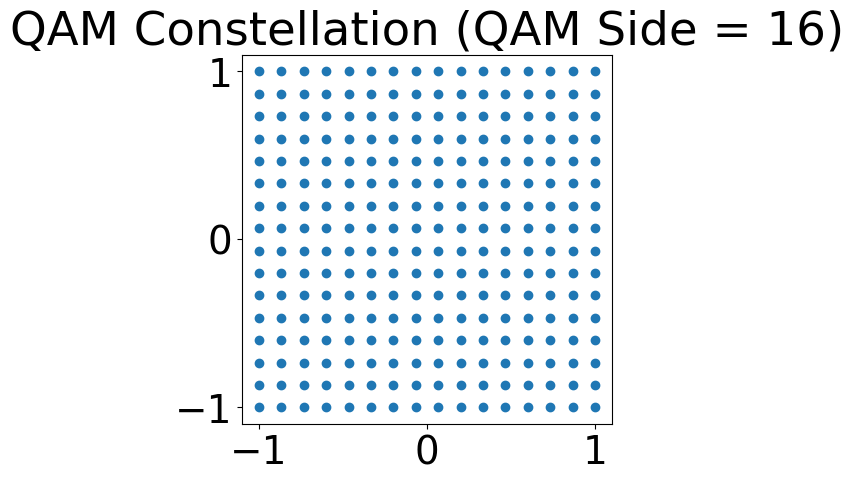

In [ ]:
class InnerProductEngine(abc.ABC):
    def quantize_to_constellation(self, inputs):
        pass

    def inner_product(self, x, y):
        """
        Compute the inner product of two complex-valued vectors x and y
        by taking the complex conjugate of y: $x\cdot y^*$.
        """
        pass

    def inner_product_real(self, x, y):
        """ Compute the inner product of two real-valued vectors x and y: $x\cdot y$. """
        pass

    def mv_product(self, x, y):
        """
        Compute the matrix-vector product of a complex-valued matrix x and a vector y
        by taking the complex conjugate of y: $x y^*$.
        """
        pass

    def mv_product_real(self, x, y):
        """ Compute the matrix-vector product of a real-valued matrix x and a vector y: $x y$. """
        pass


class QAMPhotoelectricMultiplier(InnerProductEngine):
    """
    Conditions:

    - Expects inputs to be in the range [-1, 1] in order for quantization to work properly
    """

    def __init__(self, quantize: bool, qamside: int):
        self.quantize = quantize
        self.qamside = qamside

    @tf.custom_gradient
    def quantize_to_qam(self, inputs):
        half_levels = tf.cast((self.qamside - 1) / 2, inputs.dtype)

        # Split the inputs for real and imaginary parts
        clipped_inputs = tf.clip_by_value(inputs, -1, 1)
        rescaled_inputs = (clipped_inputs + 1) * half_levels

        real_input, imag_input = tf.split(rescaled_inputs, 2, axis=-1)

        real_output = tf.round(real_input) / half_levels - 1
        imag_output = tf.round(imag_input) / half_levels - 1

        def grad(dy, variables=None):
            dy = tf.where(tf.logical_and(-1 <= clipped_inputs, clipped_inputs <= 1), dy, 0)
            return dy, None  # passthrough estimator of gradient

        return tf.concat([real_output, imag_output], axis=-1), grad

    def get_constellation(self):
        xs = tf.linspace(-1.0, 1.0, self.qamside)  # TensorFlow's equivalent to numpy's linspace
        ys = tf.linspace(-1.0, 1.0, self.qamside)

        coords_real, coords_imag = tf.meshgrid(xs, ys)  # TensorFlow's meshgrid function
        coords_real = tf.reshape(coords_real, [-1])  # Flatten the grid
        coords_imag = tf.reshape(coords_imag, [-1])

        coords = tf.expand_dims(tf.stack([coords_real, coords_imag], axis=1), axis=0)

        return coords

    def quantize_to_constellation(self, inputs):
        if self.quantize:
            return self.quantize_to_qam(inputs)
        else:
            return inputs

    def inner_product(self, x, y):
        """
        Computes the complex-valued inner product of two vectors x and y by taking the complex conjugate of the second vector: $x\cdot
        y=xy^*$. The vectors are assumed to have dimension [batch_size, 2] where the second dimension is the real and imaginary
        components. For real valued input, the second dimension can be left as zeros.
        """
        x_q = self.quantize_to_constellation(x)
        y_q = self.quantize_to_constellation(y)

        product_real = (tf.reduce_sum(x_q[..., 0] * y_q[..., 0], axis=-1) +
                        tf.reduce_sum(x_q[..., 1] * y_q[..., 1], axis=-1))

        product_imag = (tf.reduce_sum(x_q[..., 1] * y_q[..., 0], axis=-1) -
                        tf.reduce_sum(x_q[..., 0] * y_q[..., 1], axis=-1))

        return tf.stack([product_real, product_imag], axis=-1)

    def inner_product_real(self, x, y):
        """ Computes a single real-valued inner product of two real-valued vectors and returns a real-valued scalar."""
        x_ = tf.expand_dims(x, axis=-1)
        x_ = tf.concat([x_, tf.zeros(shape=x_.shape, dtype=x.dtype)], axis=-1)

        y_ = tf.expand_dims(y, axis=-1)
        y_ = tf.concat([y_, tf.zeros(shape=y_.shape, dtype=x.dtype)], axis=-1)
        return self.inner_product(x_, y_)[..., 0]

    def mv_product(self, x, y):
        x_q = self.quantize_to_constellation(x)
        y_q = self.quantize_to_constellation(y)


        product_real = (x_q[..., 0] @ y_q[..., 0] + x_q[..., 1] @ y_q[..., 1])

        product_imag = (x_q[..., 1] @ y_q[..., 0] - x_q[..., 0] @ y_q[..., 1])

        return tf.stack([product_real, product_imag], axis=-1)

    def mv_product_real(self, x, y):
        x_ = tf.expand_dims(x, axis=-1)
        x_ = tf.concat([x_, tf.zeros(shape=x_.shape, dtype=x.dtype)], axis=-1)

        y_ = tf.expand_dims(y, axis=-1)
        y_ = tf.concat([y_, tf.zeros(shape=y_.shape, dtype=x.dtype)], axis=-1)
        return self.mv_product(x_, y_)[..., 0]


pm = QAMPhotoelectricMultiplier(quantize=True, qamside=16)
plt.scatter(pm.get_constellation()[..., 0], pm.get_constellation()[..., 1])
plt.gca().set_aspect('equal')
plt.title(f'QAM Constellation (QAM Side = {pm.qamside})')

In [ ]:
import abc

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from scipy.linalg import toeplitz
from scipy.integrate import dblquad
from scipy.sparse.linalg import cg, LinearOperator
from scipy.sparse.linalg import gmres
import time

In [ ]:
import abc

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from scipy.linalg import toeplitz
from scipy.integrate import dblquad
from scipy.sparse.linalg import cg, LinearOperator
from scipy.sparse.linalg import gmres
import time

In [ ]:
import abc

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from scipy.linalg import toeplitz
from scipy.integrate import dblquad
from scipy.sparse.linalg import cg, LinearOperator
from scipy.sparse.linalg import gmres
import time

In [ ]:
import abc

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from scipy.linalg import toeplitz
from scipy.integrate import dblquad
from scipy.sparse.linalg import cg, LinearOperator
from scipy.sparse.linalg import gmres
import time

In [ ]:
import abc

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from scipy.linalg import toeplitz
from scipy.integrate import dblquad
from scipy.sparse.linalg import cg, LinearOperator
from scipy.sparse.linalg import gmres
import time

In [ ]:
def Low_Precision_MVP(A_Normalized, x, max_A, qam_module):
  """
    Implements a low-precision matrix-vector product (MVP) with quantization.

    Parameters:
        A_Normalized (ndarray): Normalized matrix A between (-1,1).
        x (ndarray): Input vector.
        A_sum_vec (ndarray): Sum of rows of A.
        min_A (float): Minimum value of |A|.
        max_A (float): Maximum value of |A|.
        bit_precision (int): Bit precision for quantization.

    Returns:
        ndarray: Result of the matrix-vector product with quantization effects.
    """


  # Normalize x
  max_x = np.max(abs(x))
  x_Normalized = x / max_x

  #b_Normalized = A_Normalized @ x_Normalized;

  # MVP
  A_separated_stack = np.stack((A_Normalized.real, A_Normalized.imag), axis=-1)
  x_Normalized = x_Normalized.reshape(len(x),1)
  x_Normalized = np.conj(x_Normalized)
  x_separated_stack = np.stack((x_Normalized.real, x_Normalized.imag), axis=-1)
  A_Normalized_tf = tf.convert_to_tensor(A_separated_stack, dtype=tf.float64)
  x_Normalized_tf = tf.convert_to_tensor(x_separated_stack, dtype=tf.float64)
  b_Quantized_tf = qam_module.mv_product(A_Normalized_tf, x_Normalized_tf)

  # Quantizing the results
  b_Numpy = b_Quantized_tf.numpy()
  real_part = b_Numpy[..., 0].flatten()
  imaginary_part = b_Numpy[..., 1].flatten()
  b_Numpy = real_part + 1j * imaginary_part
  max_b = np.max(abs(b_Numpy))
  b_Quantized_tf = b_Quantized_tf / max_b  # Normalizing
  b_Quantized_tf = qam_module.quantize_to_constellation(b_Quantized_tf)
  b_Quantized_tf = b_Quantized_tf * max_b  # Denormalizing
  b_Quantized = b_Quantized_tf.numpy()
  real_part = b_Quantized[..., 0].flatten()
  imaginary_part = b_Quantized[..., 1].flatten()
  b_Quantized = real_part + 1j * imaginary_part

  b = b_Quantized * max_x * max_A


  return b

In [ ]:
def Low_Precision_Sparse_Band_MVP(A_Sparse_Band, A_Band, x, max_A, num_of_diag, qam_module):

  b = Low_Precision_MVP(A_Sparse_Band, x, max_A, qam_module)
  #b = A_Sparse_Band @ x * max_A

  # MVP

  if num_of_diag >= 0:

    N = len(x)
    for i in range(N):

      j_min = max(0,i - num_of_diag)
      j_max = min(N-1,i + num_of_diag)


      for j in range(j_min,j_max+1):
        b[i] += A_Band[abs(i - j), min(i,j)] * x[j]



  return b

Bit Precision: 64, Time: 0.3502 sec, Iterations: 35, Final Relative Error: 4.08e-04
Bit Precision: 32, Time: 0.5307 sec, Iterations: 35, Final Relative Error: 4.08e-04
Bit Precision: 16, Time: 0.9086 sec, Iterations: 63, Final Relative Error: 3.29e-03
Bit Precision: 8, Time: 1.4159 sec, Iterations: 101, Final Relative Error: 2.13e-01


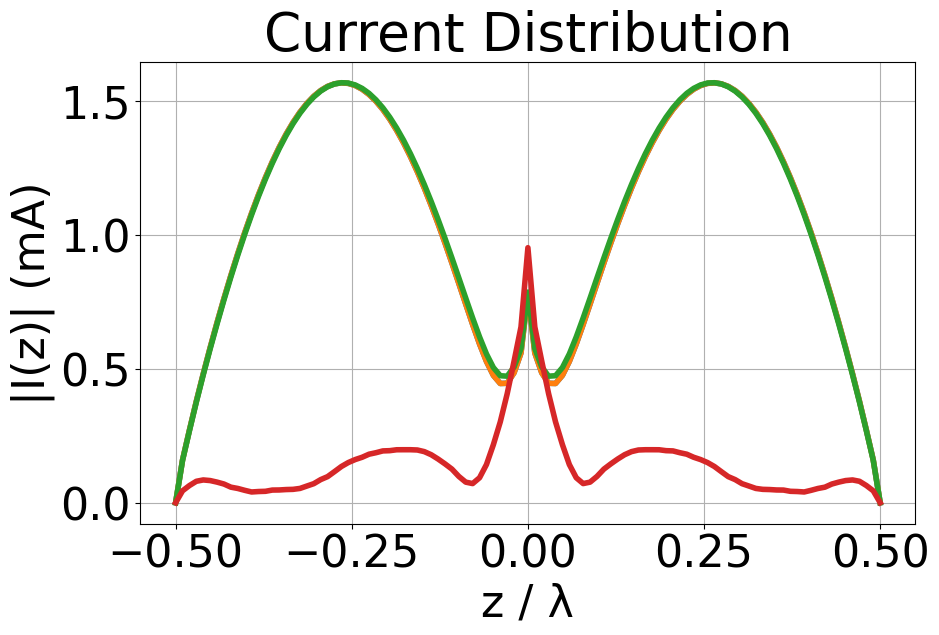

In [ ]:
# Bit Precision Convergance


plt.figure(figsize=(10, 6))


# Consider a case of 101 points

N = 101
# Generate Matrices
dz = 2 * L / (N + 1)
zn = np.linspace(-L, L, N + 2)

# Psi calculation using Reff approach
Reff = np.zeros(N + 1)
for n in range(N+1):
    delta = (n - 1) * dz
    alpha = 2 * dz + delta
    beta = dz + delta
    Reff[n] = dz**2 / (
        alpha * np.arcsinh(alpha / a)
        - 2 * beta * np.arcsinh(beta / a)
        + delta * np.arcsinh(delta / a)
        - np.sqrt(alpha**2 + a**2)
        - np.sqrt(delta**2 + a**2)
        + 2 * np.sqrt(beta**2 + a**2)
    )

psi = np.exp(-1j * k0 * Reff) / (4 * np.pi * Reff)

# Constructing F and C matrices
F = 1j * k0 * etta0 * dz**2 * psi[:N]
C = (
    -1j
    * etta0
    / k0
    * (2 * psi[:N] - psi[1:N + 1] - np.concatenate(([psi[1]], psi[:N - 1])))
)

# Constructing the system matrix A
A_row = C + F
A = toeplitz(A_row, A_row)

# Delta Gap Excitation
b = np.zeros(N, dtype=complex)
b[(N - 1) // 2] = V0

# Preprocessing on the matrix
num_of_diag = 0
A_Band = np.zeros((num_of_diag + 1, N),dtype=complex)

if num_of_diag >= 0:
  for l in range(num_of_diag + 1):
    for n in range(N - l):
      A_Band[l,n] = A[n,l + n]

  mask = (np.triu(np.ones((N, N)), k=num_of_diag+1) + np.tril(np.ones((N, N)), k=-(num_of_diag+1)))
  A_Sparse_Band = A * mask
else:
  A_Sparse_Band = A

max_A = np.max(abs(A_Sparse_Band))
A_Normalized = A_Sparse_Band/max_A

# Loop over different bit precisions

bit_precision_values = [64, 32, 16, 8]



for i in range(4):

    bit_precision = bit_precision_values[i]
    pm = QAMPhotoelectricMultiplier(quantize=True, qamside= 2 ** bit_precision)

    # Iterative Solver (Conjugate Gradient)
    x0 = np.random.rand(N) * b  # Random initial guess
    x0 = np.zeros(N)
    tol = 1e-3
    maxit = N

    # Low Precision MVP Model:
    def MVP_func(x):
      return Low_Precision_Sparse_Band_MVP(A_Normalized,A_Band, x, max_A, num_of_diag, pm)
    A_linop = LinearOperator((N, N), matvec=MVP_func, dtype=np.float64)

    counter = gmres_counter()

    # Solve the system using GMRES
    start_time = time.time()
    x, exitCode = gmres(A_linop, b, x0=x0, rtol=tol, maxiter=maxit, restart= N
                        , callback=counter, callback_type='legacy')
    end_time = time.time()

    final_error = np.linalg.norm(A @ x - b) / np.linalg.norm(b)

    print(f"Bit Precision: {bit_precision}, Time: {end_time - start_time:.4f} sec, "
          f"Iterations: {counter.niter}, Final Relative Error: {final_error:.2e}")

    # Plot Charge Distribution

    # Append zeros to the current distribution
    I = np.concatenate(([0], x, [0]))

    # Final Current Distribution Display

    plt.plot(zn / lambda0, np.abs(I) * 1e3, linewidth=4, label=f"bit precision ={bit_precision}")
    plt.xlabel("z / λ")
    plt.ylabel("|I(z)| (mA)")
    plt.title("Current Distribution")
    plt.grid(True)


plt.show()

Bit Precision: 64, Time: 1.6834 sec, Iterations: 35, Final Relative Error: 4.08e-04
Bit Precision: 32, Time: 0.9983 sec, Iterations: 35, Final Relative Error: 4.08e-04
Bit Precision: 16, Time: 0.4007 sec, Iterations: 35, Final Relative Error: 4.10e-04
Bit Precision: 8, Time: 1.0716 sec, Iterations: 101, Final Relative Error: 2.07e-02
Bit Precision: 8, Time: 1.0521 sec, Iterations: 101, Final Relative Error: 2.82e-03
Bit Precision: 8, Time: 1.0721 sec, Iterations: 101, Final Relative Error: 3.73e-04


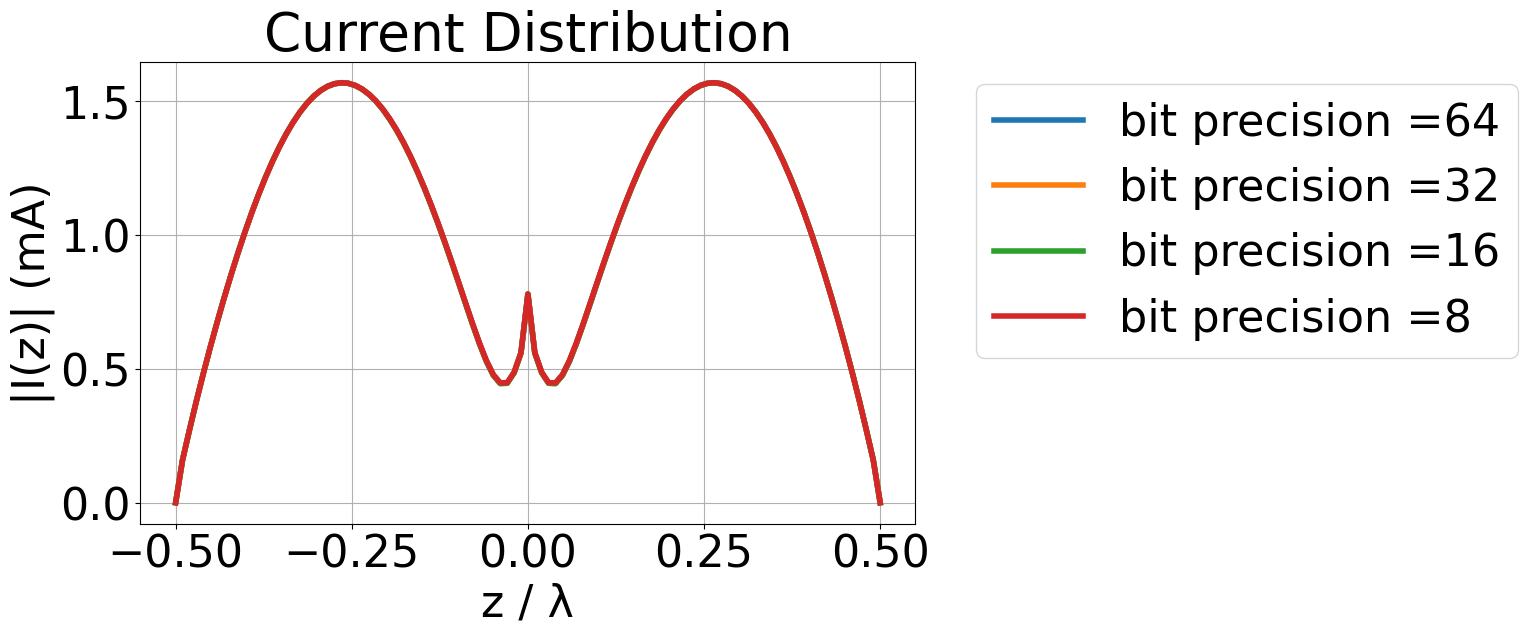

In [ ]:
# Mixed Precision


plt.figure(figsize=(10, 6))
plt.rcParams.update({'font.size': 32})



# Consider a case of 101 points

N = 101
# Generate Matrices
dz = 2 * L / (N + 1)
zn = np.linspace(-L, L, N + 2)

# Psi calculation using Reff approach
Reff = np.zeros(N + 1)
for n in range(N+1):
    delta = (n - 1) * dz
    alpha = 2 * dz + delta
    beta = dz + delta
    Reff[n] = dz**2 / (
        alpha * np.arcsinh(alpha / a)
        - 2 * beta * np.arcsinh(beta / a)
        + delta * np.arcsinh(delta / a)
        - np.sqrt(alpha**2 + a**2)
        - np.sqrt(delta**2 + a**2)
        + 2 * np.sqrt(beta**2 + a**2)
    )

psi = np.exp(-1j * k0 * Reff) / (4 * np.pi * Reff)

# Constructing F and C matrices
F = 1j * k0 * etta0 * dz**2 * psi[:N]
C = (
    -1j
    * etta0
    / k0
    * (2 * psi[:N] - psi[1:N + 1] - np.concatenate(([psi[1]], psi[:N - 1])))
)

# Constructing the system matrix A
A_row = C + F
A = toeplitz(A_row, A_row)

# Delta Gap Excitation
b = np.zeros(N, dtype=complex)
b[(N - 1) // 2] = V0

# Preprocessing on the matrix
num_of_diag = 3
A_Band = np.zeros((num_of_diag + 1, N),dtype=complex)

if num_of_diag >= 0:
  for l in range(num_of_diag + 1):
    for n in range(N - l):
      A_Band[l,n] = A[n,l + n]

  mask = (np.triu(np.ones((N, N)), k=num_of_diag+1) + np.tril(np.ones((N, N)), k=-(num_of_diag+1)))
  A_Sparse_Band = A * mask
else:
  A_Sparse_Band = A

max_A = np.max(abs(A_Sparse_Band))
A_Normalized = A_Sparse_Band/max_A

# Loop over different bit precisions

bit_precision_values = [64, 32, 16, 8]

count = np.zeros((4,))
final_error = np.zeros((4,))
final_tolerance = 1e-3

for i in range(4):

    bit_precision = bit_precision_values[i]
    pm = QAMPhotoelectricMultiplier(quantize=True, qamside= 2 ** bit_precision)



    # Low Precision MVP Model:
    def MVP_func(x):
      return Low_Precision_Sparse_Band_MVP(A_Normalized,A_Band, x, max_A, num_of_diag, pm)
    A_linop = LinearOperator((N, N), matvec=MVP_func, dtype=np.float64)


    # Iterative Solver (Conjugate Gradient)
    x0 = np.random.rand(N) * b  # Random initial guess
    x0 = np.zeros(N)
    x = x0
    r = b - A @ x

    while(np.linalg.norm(r)/np.linalg.norm(b) > final_tolerance and count[i] < 120):
      tol = 1e-3
      maxit = N
      counter = gmres_counter()

      # Solve the system using GMRES
      start_time = time.time()
      z, exitCode = gmres(A_linop, r, x0=x0, rtol=tol, maxiter=maxit, restart= N
                          , callback=counter, callback_type='legacy')
      end_time = time.time()


      x = x + z;
      r = b - A @ x;
      count[i] += 1
      final_error[i] = np.linalg.norm(r) / np.linalg.norm(b)


      print(f"Bit Precision: {bit_precision}, Time: {end_time - start_time:.4f} sec, "
            f"Iterations: {counter.niter}, Final Relative Error: {final_error[i]:.2e}")

    # Plot Charge Distribution

    # Append zeros to the current distribution
    I = np.concatenate(([0], x, [0]))

    # Final Current Distribution Display

    plt.plot(zn / lambda0, np.abs(I) * 1e3, linewidth=4, label=f"bit precision ={bit_precision}")
    plt.xlabel("z / λ")
    plt.ylabel("|I(z)| (mA)")
    plt.title("Current Distribution")
    plt.grid(True)
    plt.legend()

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()